# Introduction to variational inference


## Reminder on bayesian statistics
We are given a set of observations $x \in \mathbb{R}^{n \times d}$ that we try interpret using a model parametrized by a vector $\theta \in \mathbb{R}^m$.

In the case of coin toss, an observation  $x_i \in x$ is the outcome (either heads or tails), and we can parametrize the experiment by a Bernoulli law with parameter $p$ (p=0.5 for fair coin). In that case, $\theta = \lbrace p \rbrace$.

The objective in that case is finding the true parameter of the coin, to decide if it is fair or not for instance.
Using Bayes theorem, we can write 
$$ p(\theta | x) = \frac{p(x | \theta) p(\theta)}{p(x)} $$
or $$posterior =\frac{likelihood \times prior}{evidence} $$


**refine following paragraph**
In simple settings such as this one, computing the posterior distribution can be done in closed form using [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior).
The other complicated task in bayesian inference is estimating the evidence -or marginal likelihood- as it requires computing an integral that is often intractable: $p(x)= \int p(X | \theta) p(\theta) d\theta$.


The solution to work around this issue is to fall back on aproximating the true posterior. The most popular methods are Markov Chain Monte Carlo ([MCMC](https://github.com/johnhw/mcmc_demo_2019.git) and Variational Inference (see next section for details). MCMC are sampling-based methods that take advantage of the law of large numbers for computing integrals using $\mathbb{E}_p \lbrack f(X) \rbrack = \int f(x) p(x) dx $. 




## Variational Inference

For consistency with litterature, let us denote the latent variables $z \in \mathbb{R}^m$ (instead of $\theta$).
Our objective is to find a good approximation of the quantity $$p(z | x) =\frac{p(x | z) p(z)}{p(x)} $$ given that the quantity $p(x)$ is not tractable.


VI consists in choosing a distribution $q^*$ among a set $\mathcal{Q}$ that is "close" to the true posterior. That distance between probability distributions can be measured using the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).


Mathematically, we can write this as an optimization problem: 
$$q^*(z) = \underset{q(z) \in \mathcal{Q}}{\text{arg min}}~ \mathrm{KL}(q(z) || p(z|x) $$
The trick consists in optimizing a surrogate of this objective function, since the presence of the marginal likelihood makes it intractable

$
\begin{equation}
\begin{split}
\mathrm{KL}(q(z) || p(z|x)) & =  \mathbb{E}_q \lbrack log \frac{q(z)}{p(z | x)} \rbrack \\
    &= \mathbb{E}_q \lbrack log(q(z)) - log(p(z, x)) \rbrack + \mathbb{E}_q \lbrack p(x) \rbrack
\end{split}
\end{equation}
$

As $p(x)$ is independant of $q(z)$, minimizing the KL divergence between $q$ and $p$ is equivalent to minimizing the first term. 

We call evidence of lower bound the expectancy that we want to maximize.

$
\begin{equation}
\begin{split}
\mathrm{ELBO}(q(z)) &= \mathbb{E}_q \lbrack log~p(z,x) \rbrack - \mathbb{E}_q \lbrack log~q(z) \rbrack  \\
    &= \mathbb{E}_q \lbrack log~p(z, x) \rbrack - \mathrm{KL}(q(z) || p(z)) 
\end{split}
\end{equation}
$

The first represents the likelihood of the data whereas the second one represents the distance between the variational distribution and the prior.


Our objective can therefore be written as 
$$ q^*(z) = \underset{q(z) \in \mathcal{Q}}{\text{arg max}}~ \mathbb{E}_q \lbrack log~p(z, x) \rbrack - \mathrm{KL}(q(z) || p(z)) $$

### Coordinate Ascent Variational Inference
The CAVI consists in iteratively modifying latent variables to reach an optimum of the ELBO. At each step, we keep all the variables constant, and update one of them in the direction that increases the objective.

Formally, we update the coordinate $j$ following  
$$q_j^*(z_j)= exp\lbrace \mathbb{E}_{-j} \lbrack \log~ p(z_j, z_{-j},x) \rbrack  \rbrace $$


## A practical example: Gaussian Mixture Model



Let's consider a dataset of $n$ points.

The gaussian mixture model assumes the samples are drawn from a mixture of K gaussian distributions with mean $\mu_1 \dots \mu_K$ and variances $\sigma_1 \dots \sigma_K$. 

Therefore, the latent variables of that model are the K means and variances as well as $n$ one-hot-vectors $c_i$ that indicate from which distribution the sample $x_i$ has been drawn from.

The variational density can then be written $q(\mu, c) = \displaystyle\prod_{k=1}^{K} q(\mu_k, m_k, s_k^2) \displaystyle\prod_{i=1}^{n}q(c_i, \phi_i)$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

sns.set()

In [2]:
%matplotlib inline

In [25]:
a = np.ones((5, 2))
a * [2, 3]

array([[2., 3.],
       [2., 3.],
       [2., 3.],
       [2., 3.],
       [2., 3.]])

In [110]:
def generate_data(n_points=1500, ratio=(0.5, 0.25, 0.25), mu_1=[3, 1], sigma1=[1, 0.5],
                 mu_2=[-2, 2], sigma2=[0.2, 0.2], mu_3=[1, 2], sigma3=[0.8, 2]):
    n1 = int(n_points * ratio[0])
    n2 = int(n_points * ratio[1])
    n3 = int(n_points * ratio[2])
    
    mu1 = np.array([mu_1]*n1)
    mu2 = np.array([mu_2]*n2)
    mu3 = np.array([mu_3]*n3) 
    
    x1 = np.random.randn(n1, 2) * sigma1 + mu1
    y1 = np.ones((n1, 1))
    x2 = np.random.randn(n2, 2) * sigma2 + mu2
    y2 = 2 * np.ones((n2, 1))
    x3 = np.random.randn(n3, 2) * sigma3 + mu3
    y3 = 3 * np.ones((n3, 1))
    
    x1 = np.hstack((x1, y1))
    x2 = np.hstack((x2, y2))
    x3 = np.hstack((x3, y3))
    x = np.vstack((x1, x2, x3))
    np.random.shuffle(x)
    return x
    
x = generate_data()
print(x.shape)


(1500, 3)


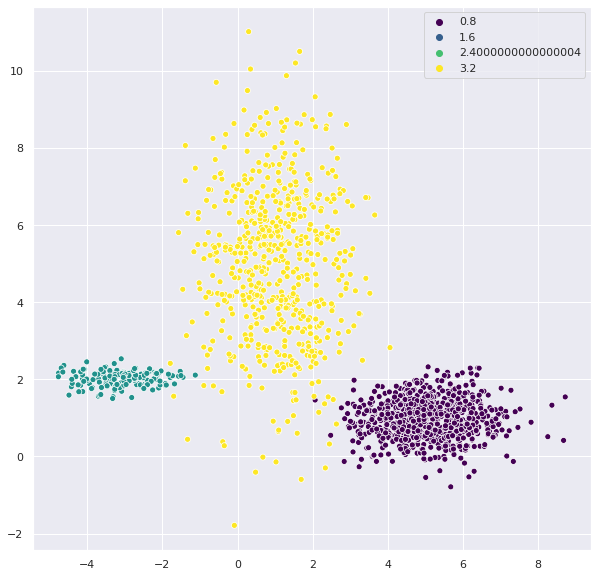

In [122]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=x[:, 2], palette='viridis')

In [98]:
COLORS = ['magenta', 'darkorange', 'turquoise', 'green', 'red', 'indigo', 'aqua']

def make_ellipses(gmm, ax, n_components, colors=COLORS):
    colors = colors[:n_components]
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.25)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

/home/valentin/workspace/pythonProjects/.venvs_python37/venv-ml/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/valentin/workspace/pythonProjects/.venvs_python37/venv-ml/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


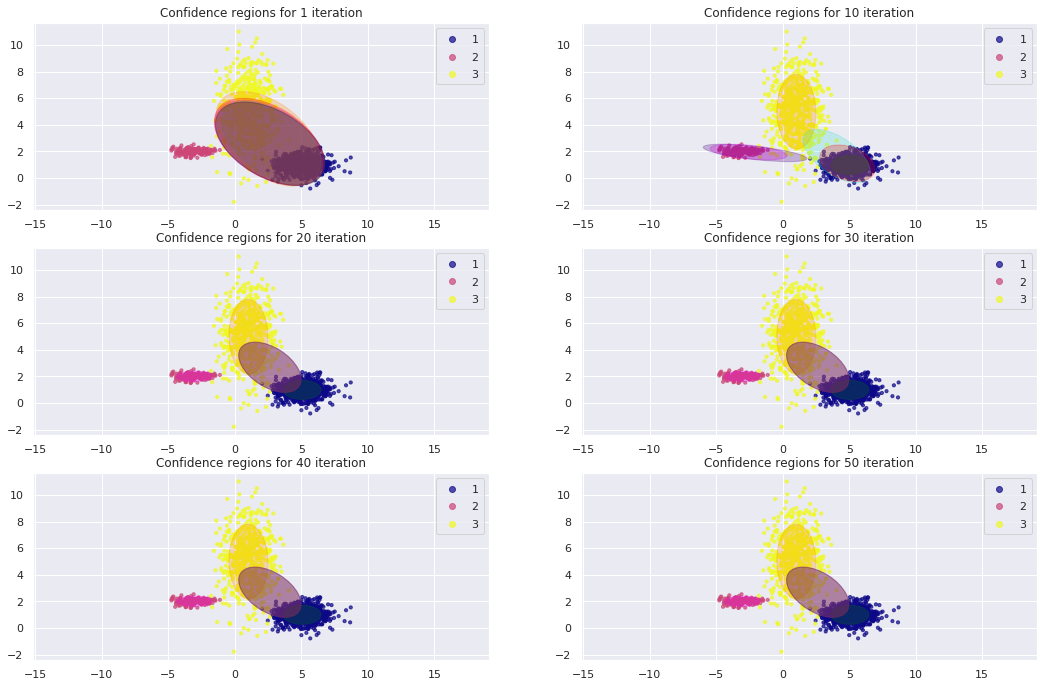

In [121]:
x = generate_data(n_points=1500, ratio=(0.5, 0.1, 0.4), mu_1=[5, 1], sigma1=[1, 0.5],
                 mu_2=[-3, 2], sigma2=[0.7, 0.2], mu_3=[1, 5], sigma3=[1, 2])

n_iter = np.linspace(1, 50, num=6, dtype=int)
COMPONENTS = 6
weight_prior = 1e-5
estimators = [
    BayesianGaussianMixture(n_components=COMPONENTS, tol=1e-7, max_iter=i, init_params='random', 
                            weight_concentration_prior=weight_prior,
                            random_state=0) for i in n_iter]
plt.figure(figsize=(18, 20))
for i, estim in enumerate(estimators):
    estim.fit(x)
    ax = plt.subplot(5, 2, 1 + i)
    make_ellipses(estim, ax, n_components=estim.n_components)
    scatter = ax.scatter(x=x[:, 0], y=x[:, 1], c=x[:, 2], s=10, cmap='plasma', alpha=0.7)
    legend = ax.legend(*scatter.legend_elements(prop='colors'))
    plt.title('Confidence regions for {} iteration'.format(n_iter[i]))

## Stochastic Variational Inference

The main drawback of CAVi algorithm is that each iteration requires computing the gradient of the loss, which does not scale well for large datasets.

To fix this, stochastic VI aims at computing cheap unbiased estimates of the gradients at each iteration (same as in numerical optimization).
$$ \mathcal{L}_{SVI}(q) = \displaystyle\sum_{i=1}^{b} \mathbb{E}_q \lbrack \log p(z_ ...) \rbrack $$